# Single Family Property Values

## Goals:

- Explore the effects of the number of bedrooms, bathrooms and square footage of Single Family Properties that had a transaction in 2017.


- Construct a ML regression model that accurately predicts property tax value.

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt

import wrangle as w
import viz as v
import model as m

import env
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

# Acquire

- Data acquired from zillow database


- It contained 52,441 rows and 7 columns before cleaning


- Each row represents a Single Family Property that had a transaction in 2017


- Each column represents a feature that describes the Single Property Home

In [2]:
# Acquiring data and clean-up
df = w.wrangle_zillow()

# Prepare

- Check for nulls (nulls were found and removed)


- Renamed columns for readability


- Optimized data types to integers where possible without losing data


- Split data into train, validate, and test sets


- Properties with 6 or more bathrooms and bedrooms were considered outliers and removed.


- Properties with a tax value greater than 2,000,000 were considered outliers and removed.


- Properties with a square footage greater than 10,000 ft^2 were considered outliers and removed.


- We are left with 50790 rows, 97% of data remains after cleaning

# Data Dictionary

| Feature | Definition |
| :- | :- |
| bedrooms | Integer, # of bedrooms in a property |
| bathrooms | Decimal value, # of bathrooms in a property, including fractional bathrooms |
| sq_feet | Integer, calculated total living area in a property |
| tax_value | Integer, total tax assessed value of the parcel, our target variable |
| year_built | Integer, the year a property was built |
| tax_amount | Decimal value, total property tax assessed for that assessment year |
| fips | Integer, Federal Information Processing Standard code (county) |

In [3]:
# Data split into train, validate, and test
train, validate, test = w.split_data(df)

# Explore

## Questions:

- Are the number of bedrooms related to tax value?


- Are the number of bathrooms related to tax value?


- Is square footage related to tax value?


- Is there an equal distribution of properties in each county?

# Are the number of bedrooms related to tax value?

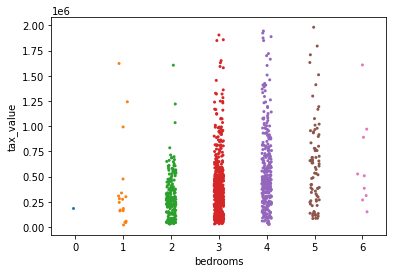

In [4]:
# get visualization of bedrooms v tax value
v.get_strip('bedrooms')

- There appears to be more properties at a higher tax value that have 2 or more bedrooms.

#### I will use a correlation test to determine if 'bedrooms' and 'tax_value' are related.

- I will use a confidence interval of 95% with alpha set to .05

#### Ho: 'bedrooms' and 'tax_value' are independent of each other.

#### Ha: 'bedrooms' and 'tax_value' are related.

In [5]:
# get correlation test
v.get_corr('bedrooms')

corr = 0.2747
p    = 0.0000


### The p-value is lower than our alpha, giving us the evidence to support that a relationship exists between 'bedrooms' and 'tax_value'. With our null hypothesis rejected, and the positive correlation observed in the train data, I believe that using 'bedrooms' in modeling will likely have a significant positive impact on the model's accuracy.

# Are the number of bathrooms related to tax value?

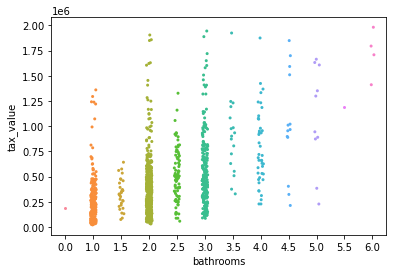

In [6]:
# get visualization of bathrooms v tax value
v.get_strip('bathrooms')

- There appears to be more properties at a higher tax value that have 2 or more bathrooms.


- There is a significant number of properties that had a transaction occur with only 1 bathroom.

#### I will use a correlation test to determine if 'bathrooms' and 'tax_value' are related.

- I will use a confidence interval of 95% with alpha set to .05

#### Ho: 'bathrooms' and 'tax_value' are independent of each other.

#### Ha: 'bathrooms' and 'tax_value' are related.

In [7]:
# get correlation test
v.get_corr('bathrooms')

corr = 0.5052
p    = 0.0000


### The p-value is lower than our alpha, giving us the evidence to support that a relationship exists between 'bathrooms' and 'tax_value'. With our null hypothesis rejected, and the positive correlation observed in the train data, I believe that using 'bathrooms' in modeling will likely have a significant positive impact on the model's accuracy.

# Is square footage related to tax value?

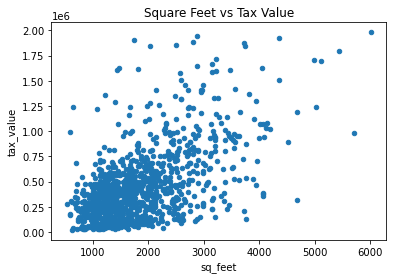

In [8]:
# get visualization of sq feet v tax value
v.get_scatter_sq_feet()

- It appears to be that properties with more square footage have a higher tax value.

#### I will use a correlation test to determine if 'sq_feet' and 'tax_value' are related.

- I will use a confidence interval of 95% with alpha set to .05

#### Ho: 'sq_feet' and 'tax_value' are independent of each other.

#### Ha: 'sq_feet' and 'tax_value' are related.

In [9]:
# get correlation test
v.get_corr('sq_feet')

corr = 0.5762
p    = 0.0000


### The p-value is lower than our alpha, giving us the evidence to support that a relationship exists between 'sq_feet' and 'tax_value'. With our null hypothesis rejected, and the positive correlation observed in the train data, I believe that using 'sq_feet' in modeling will likely have a significant positive impact on the model's accuracy.

# Is there an equal distribution of properties in each county?

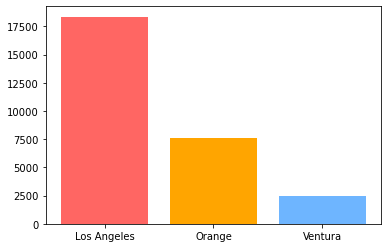

In [10]:
# get visualization of property count per county
v.get_fips()

- There appears to be an uneven distribution of properties in each county that had a transaction in 2017. Keep this in consideration once models are evaluated.

## Exploration Summary

- 'bedrooms' was found to be a driver of 'tax_value'


- 'bathrooms' was found to be a driver of 'tax_value'


- 'sq_feet' was found to be a driver of 'tax_value'


- Property distribution is uneven between 'fips'

## Features To Move Forward With

- 'bedrooms' (correlation is fairly low, but statistically significant)


- 'bathrooms' (correlation is signicant and will be used in modeling)


- 'sq_feet' (correlation is significant and will be used in modeling)


## Modeling

- I will use RMSE as my evaluation metric.


- Models will be evaluated on train and validate data.


- Model that performs best will move on to be evalutated against the test data set.

In [11]:
# scaling data for improved model perforance
train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test)

In [12]:
# separation of data for x sets and y sets
x_train_scaled = train_scaled[['bedrooms', 'bathrooms', 'sq_feet']]
y_train = train[['tax_value']]

x_validate_scaled = validate_scaled[['bedrooms', 'bathrooms', 'sq_feet']]
y_validate = validate[['tax_value']]

x_test_scaled = test_scaled[['bedrooms', 'bathrooms', 'sq_feet']]
y_test = test[['tax_value']]

## Baseline

In [13]:
# get baseline model with mean and median
m.get_baseline()

RMSE using Mean
Train/In-Sample:  355371.19 
Validate/Out-of-Sample:  347152.8

RMSE using Median
Train/In-Sample:  364925.59 
Validate/Out-of-Sample:  355040.41


- The baseline model is off by an average of 347,152.80 using the Mean tax value and an average of 355,040.41 using the median tax value of our data.

## LinearRegression (OLS)

In [14]:
# get ols results
m.get_ols()

RMSE for OLS using LinearRegression
Training/In-Sample:  286205.31265758 
Validation/Out-of-Sample:  281570.92470836977


- The OLS model is off by an average of 281,570.92 on validate.


- RMSE is better than baseline.

## LassoLars

In [15]:
# get lassolars results
m.get_lassolars()

RMSE for Lasso + Lars
Training/In-Sample:  286205.6184335364 
Validation/Out-of-Sample:  281570.55340928794


- The LassoLars model is off by an average of 281,570.55 on validate.


- RMSE is better than baseline.

## TweedieRegressor (GLM)

In [16]:
# get tweedie results
m.get_tweedie()

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  296696.93800469773 
Validation/Out-of-Sample:  288237.9091112238


- The TweedieRegressor model is off by an average of 288237.90 on validate.


- RMSE is better than baseline.

## Polynomial Regression

In [17]:
# get poly results
m.get_poly()

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  285135.8897185141 
Validation/Out-of-Sample:  280525.2753433108


- The Polynomial Regression model is off by an average of 280,525.27 on validate.


- RMSE is better than baseline.

## Comparing Models

- All models performed better than baseline on train and validate.


- Polynomial Regression yielded the lowest RMSE of all models and will move on to test set.

## Polynomial Regression on Test

In [18]:
# get test results for final model
m.get_poly_test()

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  285135.8897185141 
Test/Out-of-Sample:  287604.14311415475


### Calculating R^2 Coefficient for Variance

In [19]:
# get model performance for R^2 evaluation
m.performance()

R^2 Coefficient for Variance:  0.3526390577476429


- Our features chosen explain roughly 35% of the variance in tax value.

## Modeling Summary

- All models performed better than baseline.


- Polynomial Regression model performed best.


- Polynomial Regression model on test performed slightly worse than on validate, but better than baseline model overall.

# Conclusions

### Exploration

- There is a positive correlation between the number of bedrooms and tax value of a property.


- There is a positive correlation between the number of bathrooms and tax value of a property.


- There is a positive correlation between the amount of square footage and tax value of a property.


- There is an uneven distribution of properties in the Los Angeles County, Orange County, an Ventura County.

### Modeling

#### The final model outperformed baseline, but R^2 is low.

#### Possible reason for this:

- 'bedrooms', 'bathrooms', and 'sq_feet' are significant drivers of tax value.


- 'fips', or the county where the property is located, is also a driver of tax value.


- The county where a property is located may significantly impact tax value.

### Using the model is better than no model at all.

## Recommendations

- Continue to focus on the number of bedrooms, bathrooms, and square footage of homes as drivers of tax value.


- Evaluate the tax value of properties when properties are separated into their respective counties.


- Create a model for each county that had properties with a transaction.

## Next Steps

- Further investigate how strong 'fips' influences tax value.


- Construct additional models with properties separated by their counties and evaluate model performance then.